Simple Two-Sides A/B-test Bayesian approach. 
Consider typical landing page A/B-test for increasing number of applicants. 
Accept landing page $\\A$ was shown to $\\N$ prospect leads and given a $\\n$ conversions. $p_a = n/N$ is a observed frequency. True frequency is not equal observed frequency in practice. 

The main task in our case is estimate true possible frequency. For developing bayesian model we should make apriory distributions for our random variable. Accept our random variable has a uniform distribution щт $[0,1]$ interval.  
Accept $p_a = 0.05$ and $N = 1500$. Using Bernoulli Distribution for simulations. 

In [4]:
#Bayesian AB-test approach:
import pymc as pm
import scipy.stats as stats
import numpy as np

p_true = 0.05
N = 1500
model = pm.Model()
with model:
    p = pm.Uniform('p', lower = 0, upper = 1)

occurrences = stats.bernoulli.rvs(p_true, size = N)

print(occurrences)
print(np.sum(occurrences))
print('Observed probability in A-group: {}'.format(occurrences.mean())) 
print('Equals observed frequency and True probability: {}'.format(occurrences.mean() == p_true))

[0 0 0 ... 0 0 0]
57
Observed probability in A-group: 0.038
Equals observed frequency and True probability: False


In [6]:
with model:
    observed = pm.Bernoulli("obs", p, observed = occurrences)

In [8]:
#include the observations, which are Bernoulli
with model:
    step = pm.Metropolis()
    trace = pm.sample(18000,step=step,chains=3) 

Multiprocess sampling (3 chains in 4 jobs)
Metropolis: [p]


Sampling 3 chains for 1_000 tune and 18_000 draw iterations (3_000 + 54_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


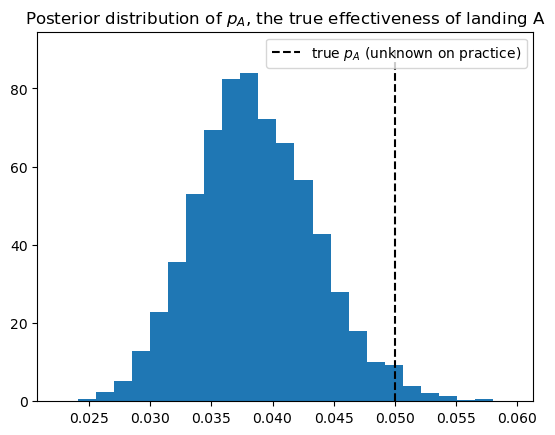

In [10]:
import matplotlib.pyplot as plt 

plt.title("Posterior distribution of $p_A$, the true effectiveness of landing A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown on practice)",color='black')
combine_3_chains = np.concatenate(trace.posterior.p.data[:,1000:])
plt.hist( combine_3_chains, bins=25, histtype="stepfilled", density=True)
plt.legend();

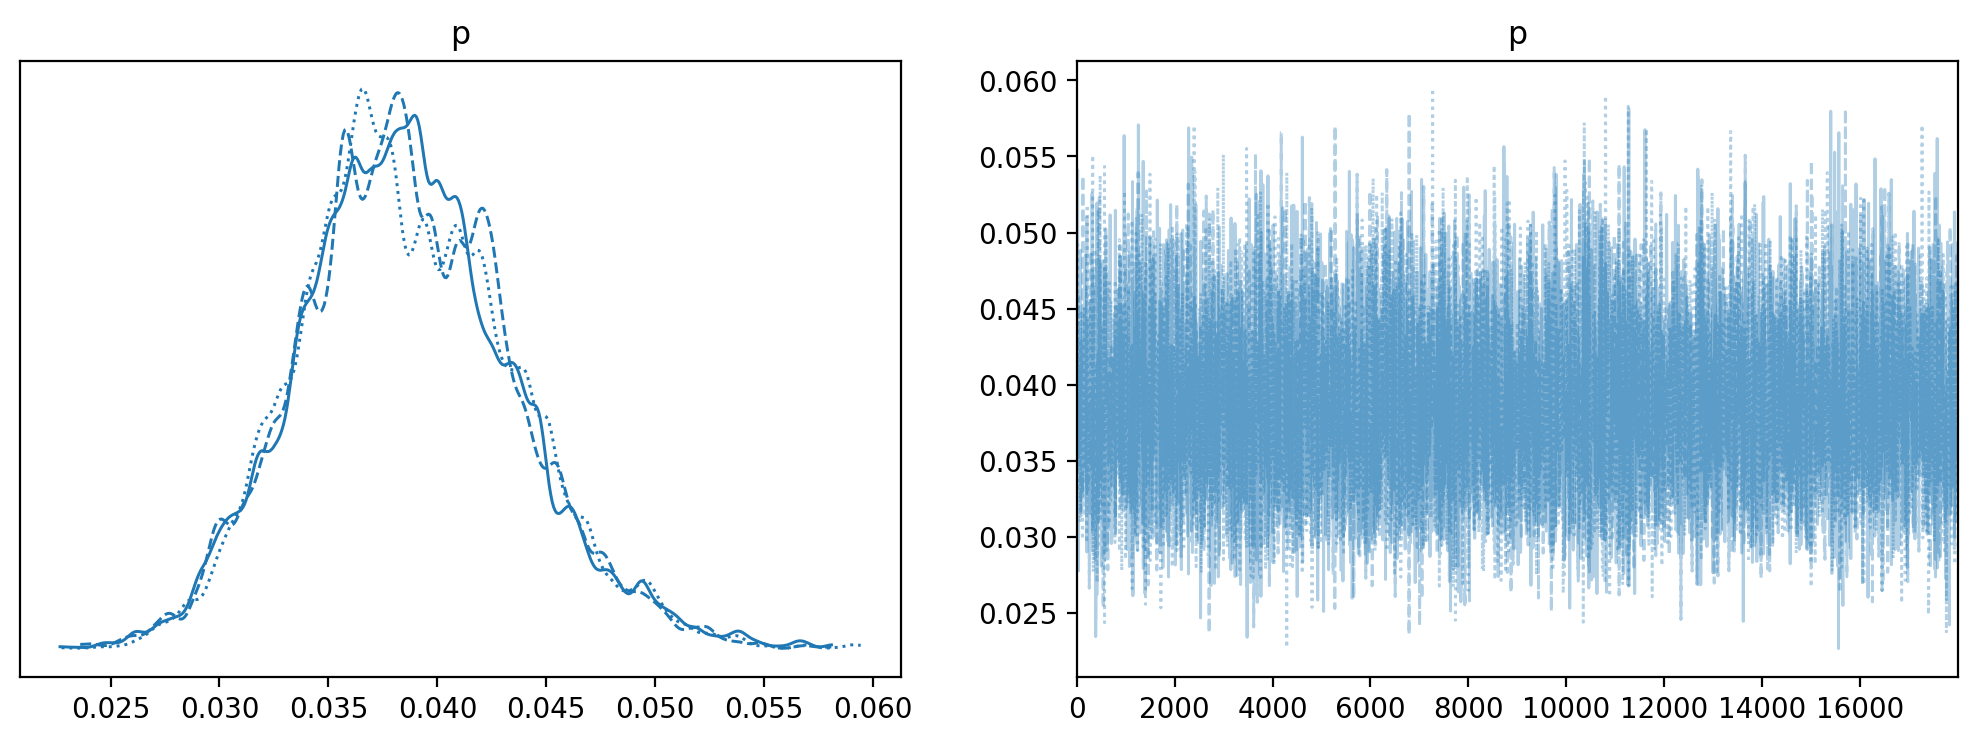

In [12]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.plot_trace(trace, figsize=(12.5, 4));

[]

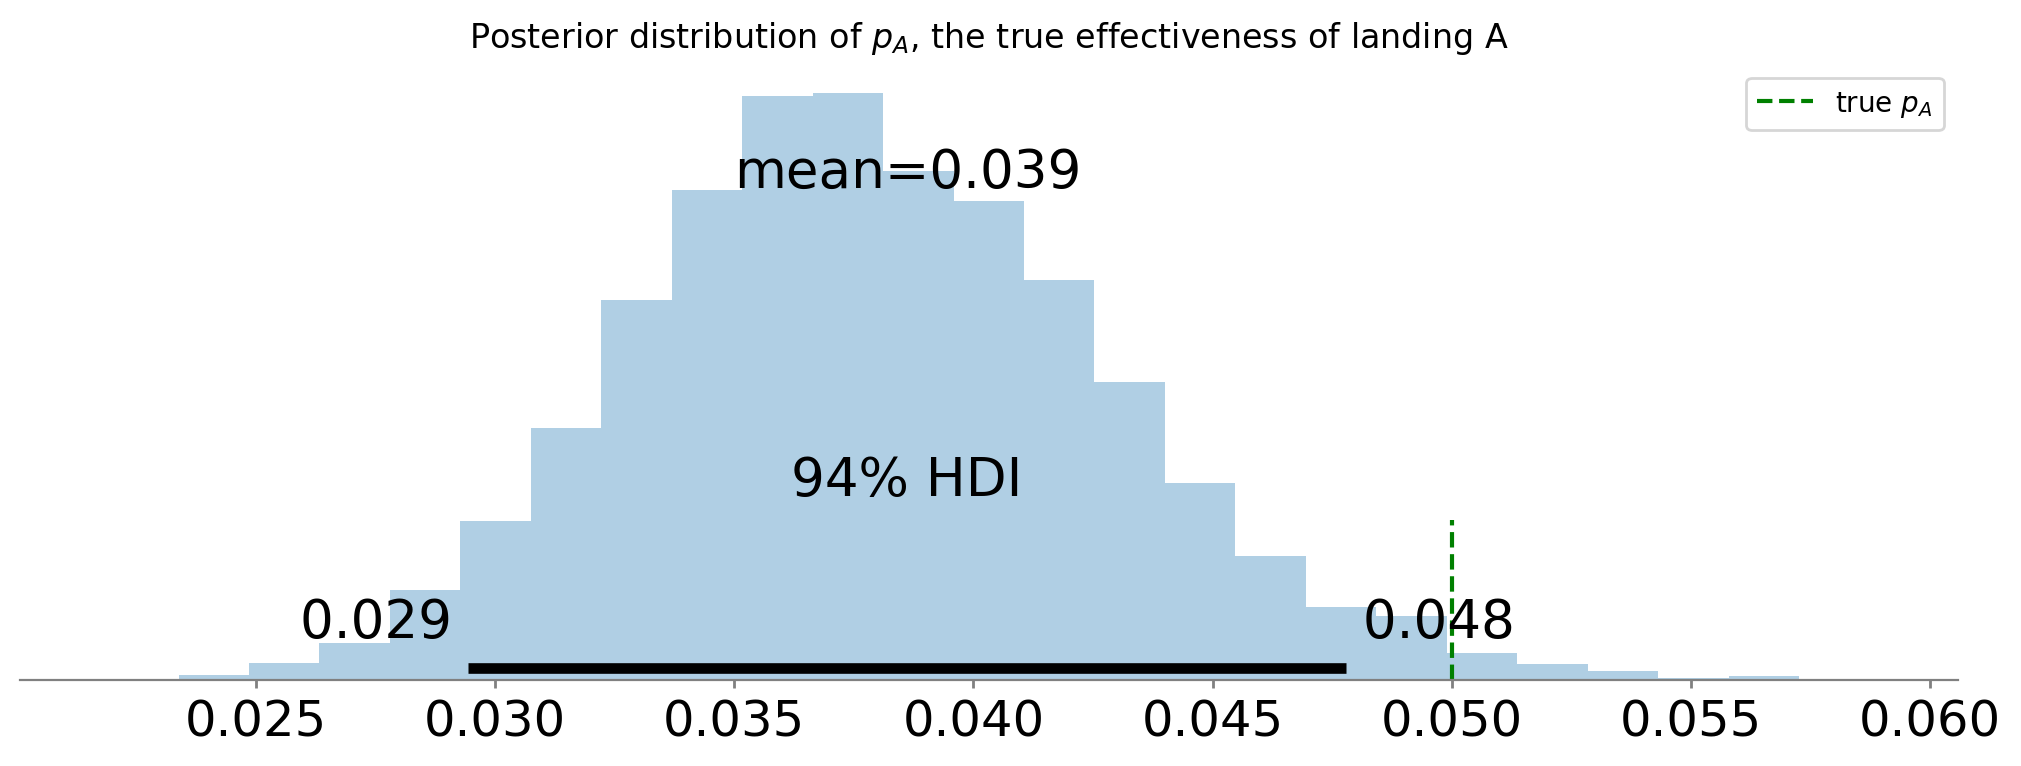

In [14]:
import matplotlib.lines as lines

ax=az.plot_posterior(trace, var_names=['p'], kind='hist',bins=25,figsize=(12.5,4))
ax.set_title("Posterior distribution of $p_A$, the true effectiveness of landing A")
ax.vlines(0.05,0, 1800,colors='green',linestyle="--", label="true $p_A$")
ax.legend()
ax.plot()

In [16]:
import pymc as pm

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")
print(np.mean(observations_A))
print(np.mean(observations_B))

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
0.04733333333333333
0.044


In [18]:
#Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)
    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step,chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [p_A]
>Metropolis: [p_B]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [20]:
p_A_samples =  np.concatenate(trace.posterior.p_A.data[:,1000:])
p_B_samples =  np.concatenate(trace.posterior.p_B.data[:,1000:])
delta_samples = np.concatenate(trace.posterior.delta.data[:,1000:])

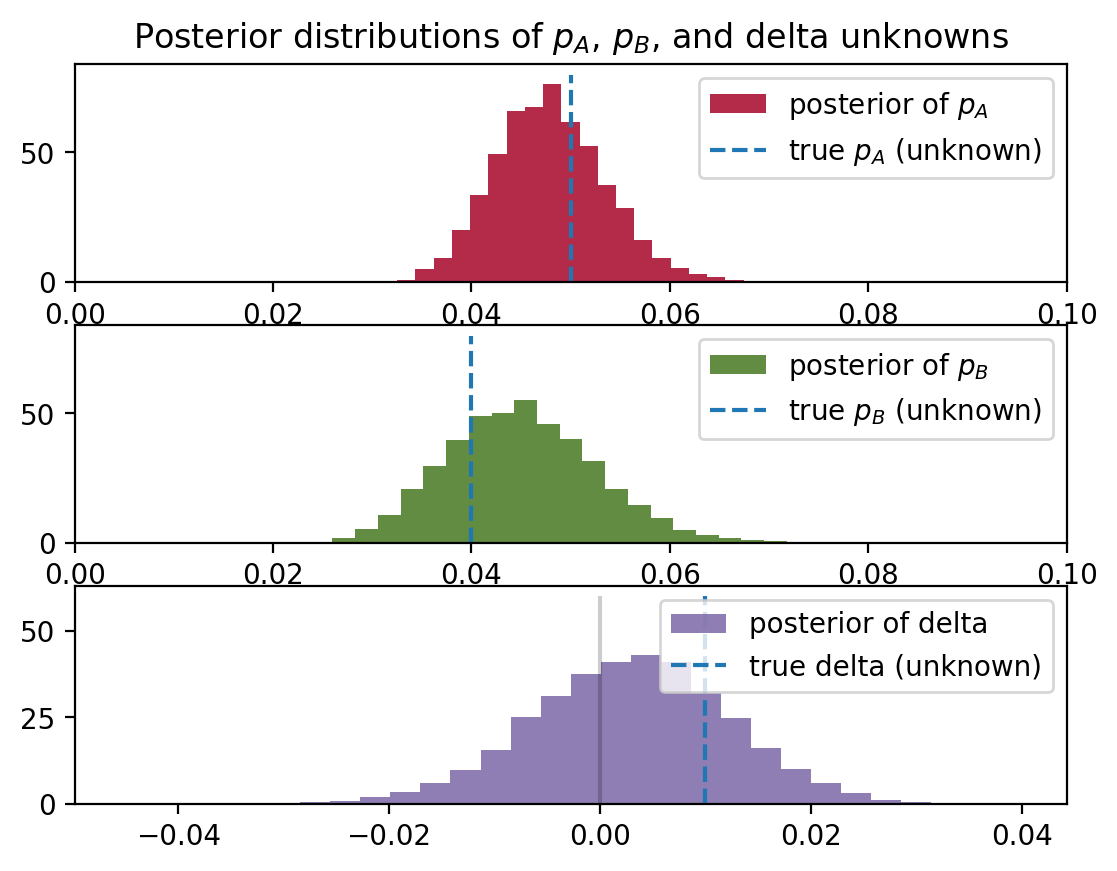

In [22]:
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [24]:
print("Probability landing A is worse than landing B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability landing A is better than landing B: %.3f" % \
    np.mean(delta_samples > 0))

Probability landing A is worse than landing B: 0.373
Probability landing A is better than landing B: 0.627
